In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2

In [9]:
# Подготовка данных для модели
y_labels = pd.read_csv('y_labels_100thsnd_withoutscaler.csv')

cnn_arrays = np.load('shuffled_combined_100thsnd_withoutscaler.npz')
X_ts = cnn_arrays['X']
ids_ts = cnn_arrays['ids']

In [10]:
# Фильтруем строки с нужными подтипами
selected_subtypes = ['RRAB', 'BY', 'DCEP', 'DSCT', 'EA', 'UG', 'EW', \
                     'M', 'SR', 'TTS']

filtered_y = y_labels[y_labels['variability_type'].isin(selected_subtypes)]
mask = np.isin(ids_ts, filtered_y['asas_sn_id'].values)
X_ts = X_ts[mask]
ids_ts = ids_ts[mask]
filtered_y = filtered_y[filtered_y['asas_sn_id'].isin(ids_ts)]


In [11]:
# Стратифицированное разделение с сохранением индексов для подклассов
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_ts,
    filtered_y['variability_type'].values,
    ids_ts,
    test_size=0.2,
    stratify=filtered_y['variability_type'],
    random_state=42
)

In [6]:
# Стратифицированное разделение с сохранением индексов для основных классов
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_ts,
    y_labels['main_class'].values,
    ids_ts,
    test_size=0.2,
    stratify=y_labels['main_class'],
    random_state=42
)

In [12]:
# Кодирование целевых переменных для подклассов
ohe_main = OneHotEncoder(sparse_output=False)
y_train_onehot = ohe_main.fit_transform(pd.DataFrame(y_train, columns=['variability_type']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val, columns=['variability_type']))

In [7]:
# Кодирование целевых переменных для основных классов
ohe_main = OneHotEncoder(sparse_output=False)
y_train_onehot = ohe_main.fit_transform(pd.DataFrame(y_train, columns=['main_class']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val, columns=['main_class']))

In [8]:
# Вычисление весов классов для подклассов
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(filtered_y['variability_type']),
    y=filtered_y['variability_type']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 1.5618289085545722,
 1: 5.2946,
 2: 2.6526052104208415,
 3: 0.8825804300716786,
 4: 0.529830881617132,
 5: 1.32365,
 6: 0.529777866720032,
 7: 0.5296188856656997,
 8: 5.018578199052133,
 9: 0.9588192683810214}

In [9]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[['BY' 2712]
 ['DCEP' 800]
 ['DSCT' 1597]
 ['EA' 4799]
 ['EW' 7994]
 ['M' 3200]
 ['RRAB' 7995]
 ['SR' 7997]
 ['TTS' 844]
 ['UG' 4418]]


In [29]:
# Вычисление весов классов для основных классов
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_labels['main_class']),
    y=y_labels['main_class']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 0.7715051266478511,
 1: 5.622285863056495,
 2: 0.4320595414349166,
 3: 1.0884677419354838,
 4: 3.4158810503005377}

In [30]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[['ECLIPSING' 22393]
 ['ERUPTIVE' 3073]
 ['PULSATING' 39985]
 ['ROTATING' 15872]
 ['cataclysmic' 5057]]


In [31]:
def scale_dataset(data):
    """Масштабируем данные с сохранением паддинга для каждого образца отдельно"""
    scaled_data = np.empty_like(data)
    
    for i in range(data.shape[0]):
        # Копируем признаки
        mag = data[i, :, 0].copy()
        mag_err = data[i, :, 1].copy()
        mjd = data[i, :, 2].copy()
        
        # Определяем границу паддинга по MJD
        non_zero_mask = mjd != 0.0
        valid_length = np.sum(non_zero_mask)
        
        if valid_length > 0:
            # Масштабируем каждый признак отдельно
            for ch, feature in enumerate([mag, mag_err, mjd]):
                scaler = StandardScaler()
                scaled_part = scaler.fit_transform(feature[:valid_length].reshape(-1, 1)).flatten()
                feature[:valid_length] = scaled_part
        
        # Сохраняем масштабированные данные
        scaled_data[i, :, 0] = mag
        scaled_data[i, :, 1] = mag_err
        scaled_data[i, :, 2] = mjd
    
    return scaled_data

# Применяем масштабирование
X_train_scaled = scale_dataset(X_train)
X_val_scaled = scale_dataset(X_val)

In [15]:
n_samples, timesteps, features = X_train.shape

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
# Коллбэк для сохранения F1
checkpoint_f1 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_f1.keras',  
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Коллбэк для сохранения val_loss
checkpoint_loss = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_loss.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    TensorBoard(log_dir='./logs'),
    checkpoint_f1,
    checkpoint_loss
]

In [4]:
def residual_block(x, filters, dilation_rate, kernel_size=3):
    # Residual block с расширенной сверткой
    original_x = x
    x = Conv1D(filters*2, kernel_size,
              padding='causal',
              dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    # Gate branch
    gated = Conv1D(filters*2, kernel_size,
                  padding='causal',
                  dilation_rate=dilation_rate)(original_x)
    gated = BatchNormalization()(gated)
    gated = Activation('sigmoid')(gated)

    # Комбинирование
    x = Multiply()([x, gated])

    # Residual connection
    x = Conv1D(filters, 1, padding='same')(x)
    res = Add()([original_x, x])

    return res

def build_wavenet_model(input_shape, num_classes):
    # Вход для временных рядов
    ts_input = Input(shape=input_shape, name='ts_input')

    # Начальный слой
    x = Conv1D(64, 3, padding='causal')(ts_input)

    # Стек residual блоков с экспоненциально растущими dilation rates
    dilation_rates = [1, 2, 4, 8, 16, 32]
    for i, rate in enumerate(dilation_rates):
        x = residual_block(x, filters=64, dilation_rate=rate)
        x = Dropout(0.2)(x)

    # Финальные слои обработки временных рядов
    x = Conv1D(128, 3, padding='causal')(x)
    x = GlobalAveragePooling1D()(x)

    # Классификатор
    output = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
    output = Dropout(0.4)(output)
    output = Dense(num_classes, activation='softmax')(output)

    return Model(inputs=ts_input, outputs=output)

In [ ]:
# Компиляция модели
model = build_wavenet_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    num_classes=len(ohe_main.categories_[0])
)
model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[F1Score(average='macro')]
)

Обучение подтипов

In [ ]:
# Обучение модели
history = model.fit(
    X_train_scaled,
    y_train_onehot,
    epochs=50,
    batch_size=128,
    #class_weight=class_weight_dict,
    validation_data=(X_val_scaled, y_val_onehot),
    callbacks=callbacks
)

Epoch 1/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.3404 - loss: 2.1090
Epoch 1: val_f1_score improved from -inf to 0.49705, saving model to /content/drive/MyDrive/withoutresamplebest_f1.keras

Epoch 1: val_loss improved from inf to 1.42938, saving model to /content/drive/MyDrive/withoutresamplebest_loss.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - f1_score: 0.3406 - loss: 2.1079 - val_f1_score: 0.4971 - val_loss: 1.4294
Epoch 2/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.5102 - loss: 1.3421
Epoch 2: val_f1_score improved from 0.49705 to 0.51846, saving model to /content/drive/MyDrive/withoutresamplebest_f1.keras

Epoch 2: val_loss improved from 1.42938 to 1.29544, saving model to /content/drive/MyDrive/withoutresamplebest_loss.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - f1_score: 0.5103 - loss: 1.3419 - val_f1_score: 0.5185 - val_loss: 1.2954
Epoch 3/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.5500 - loss: 1.2173
Epoch 3: val_f1_score 

In [ ]:
# индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1,
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 22
Train F1: 0.7020
Train loss: 0.8484
Validation F1: 0.6927
Validation Loss: 0.9346


331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step


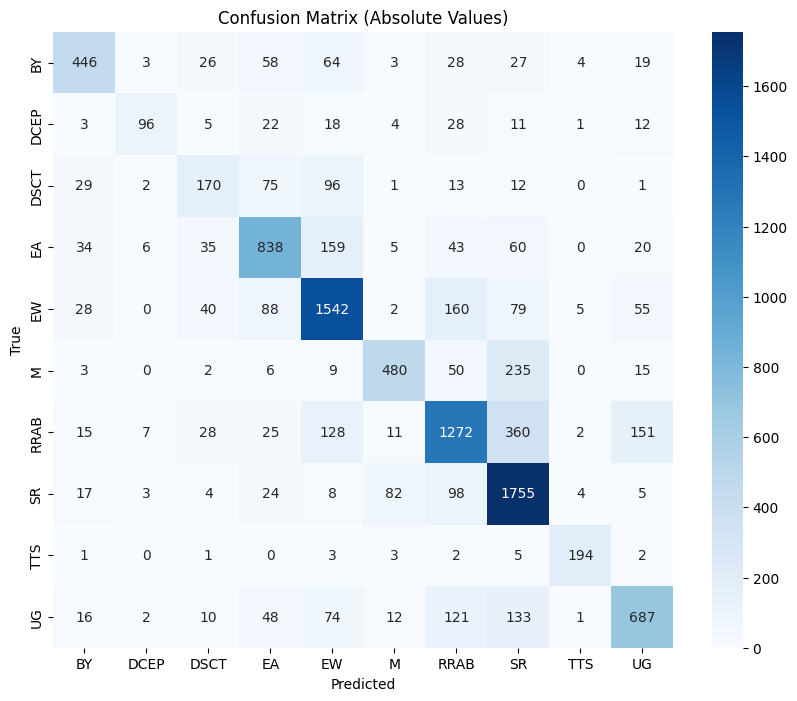

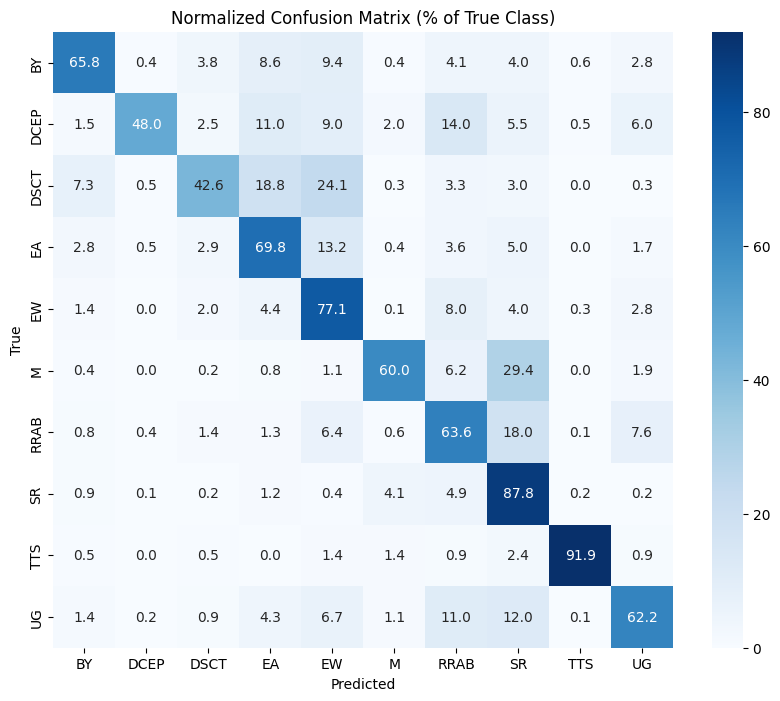

In [22]:
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

# Создание confusion matrix с абсолютными значениями
cm = confusion_matrix(y_true_classes, y_pred_classes)

#Визуализация с абсолютными значениями
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=ohe_main.categories_[0],
    yticklabels=ohe_main.categories_[0]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Absolute Values)')
plt.show()

# Визуализация с нормализацией по строкам (в процентах)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=ohe_main.categories_[0],
    yticklabels=ohe_main.categories_[0]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (% of True Class)")
plt.show()

In [90]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          BY     0.7534    0.6578    0.7024       678
        DCEP     0.8067    0.4800    0.6019       200
        DSCT     0.5296    0.4261    0.4722       399
          EA     0.7078    0.6983    0.7030      1200
          EW     0.7339    0.7714    0.7522      1999
           M     0.7960    0.6000    0.6842       800
        RRAB     0.7008    0.6363    0.6670      1999
          SR     0.6556    0.8775    0.7505      2000
         TTS     0.9194    0.9194    0.9194       211
          UG     0.7104    0.6223    0.6634      1104

    accuracy                         0.7063     10590
   macro avg     0.7314    0.6689    0.6916     10590
weighted avg     0.7108    0.7063    0.7026     10590



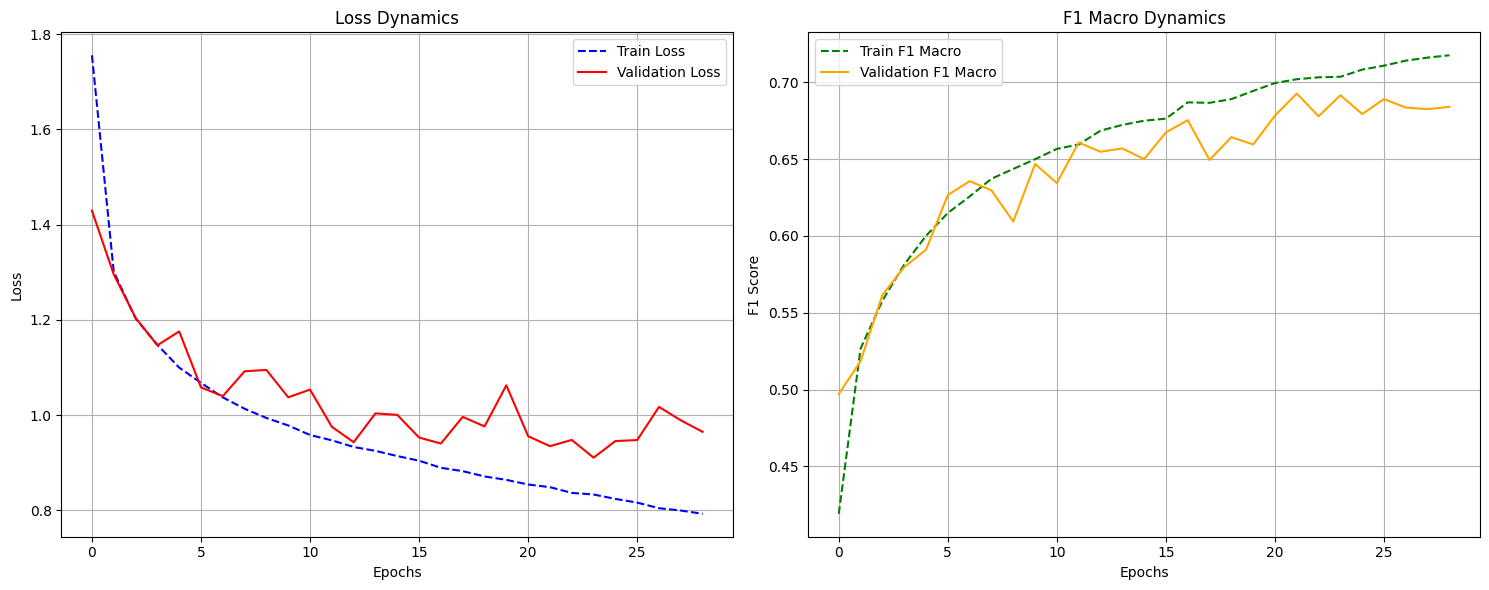

In [ ]:
plt.figure(figsize=(15, 6))

# График для Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для F1 Macro
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Train F1 Macro', color='green', linestyle='--')
plt.plot(history.history['val_f1_score'], label='Validation F1 Macro', color='orange', linestyle='-')
plt.title('F1 Macro Dynamics')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Обучение основных классов

In [ ]:
# индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1,
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 23
Train F1: 0.6372
Train loss: 0.7635
Validation F1: 0.6283
Validation Loss: 0.8231


675/675 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step


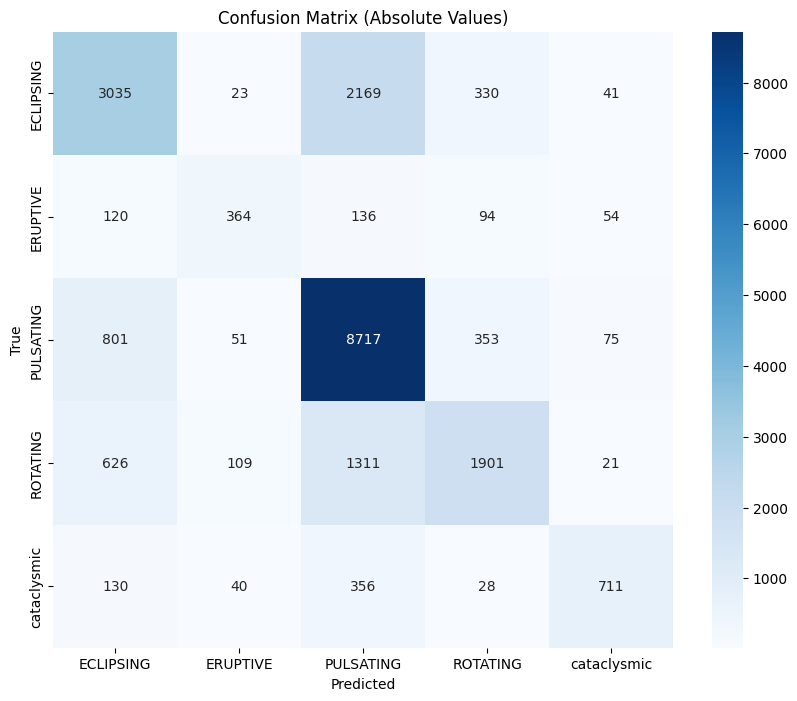

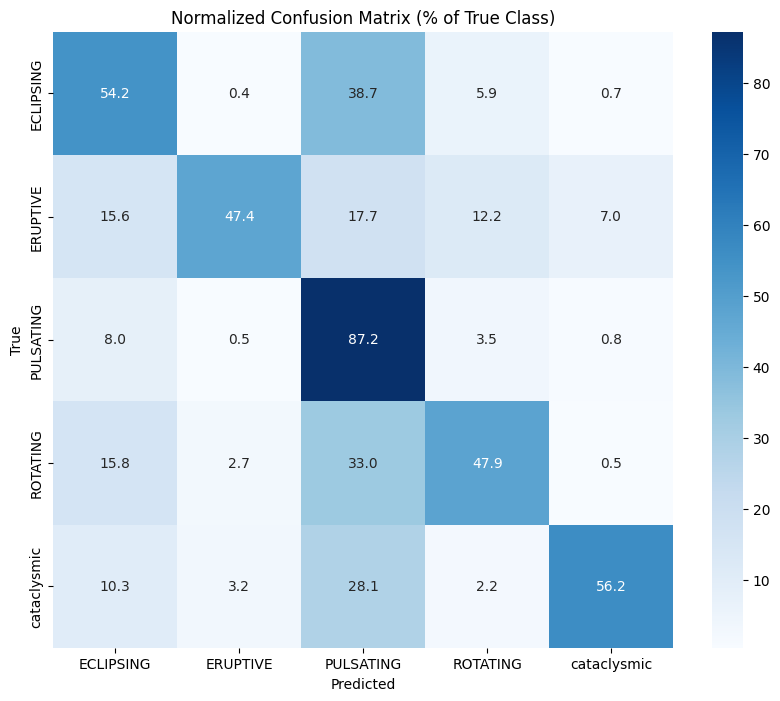

In [41]:
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

# Создание confusion matrix с абсолютными значениями
cm = confusion_matrix(y_true_classes, y_pred_classes)

#Визуализация с абсолютными значениями
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=ohe_main.categories_[0],
    yticklabels=ohe_main.categories_[0]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Absolute Values)')
plt.show()

# Визуализация с нормализацией по строкам (в процентах)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=ohe_main.categories_[0],
    yticklabels=ohe_main.categories_[0]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (% of True Class)")
plt.show()

In [54]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   ECLIPSING     0.6444    0.5420    0.5888      5598
    ERUPTIVE     0.6182    0.4766    0.5382       768
   PULSATING     0.6870    0.8717    0.7684      9997
    ROTATING     0.7014    0.4796    0.5697      3968
 cataclysmic     0.7875    0.5597    0.6543      1265

    accuracy                         0.6818     21596
   macro avg     0.6877    0.5859    0.6239     21596
weighted avg     0.6821    0.6818    0.6705     21596



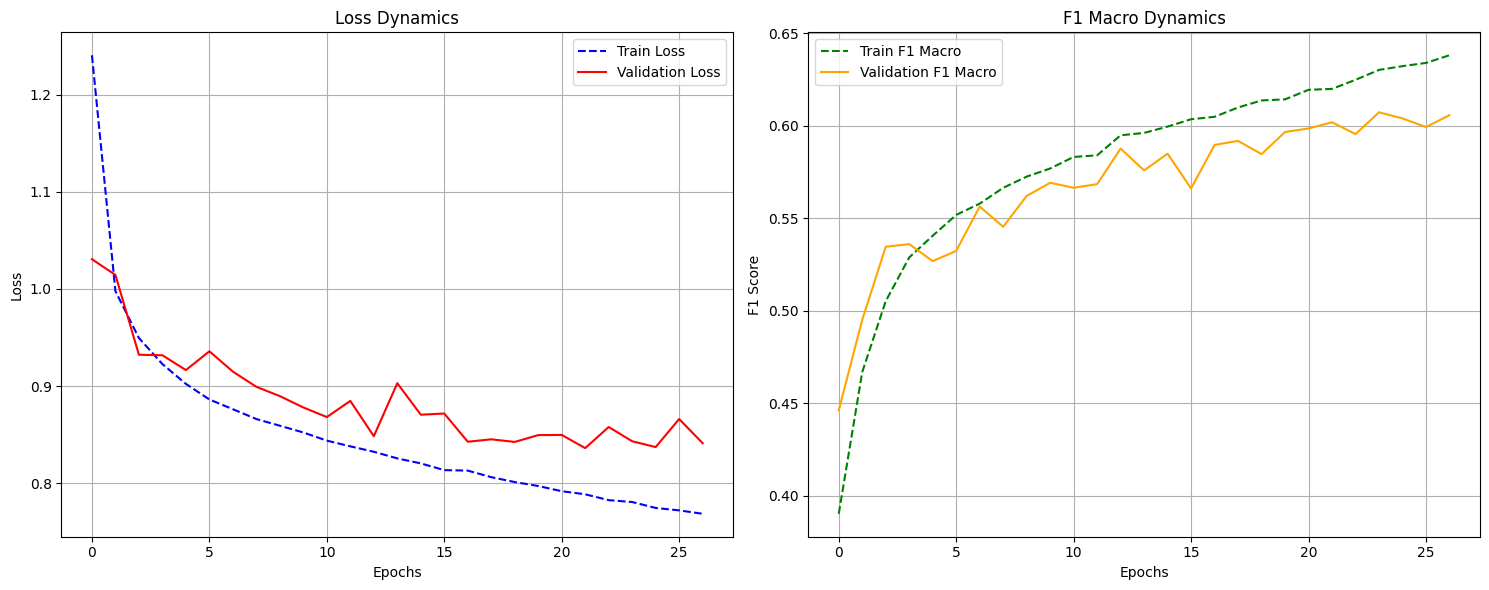

In [ ]:
plt.figure(figsize=(15, 6))

# График для Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для F1 Macro
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Train F1 Macro', color='green', linestyle='--')
plt.plot(history.history['val_f1_score'], label='Validation F1 Macro', color='orange', linestyle='-')
plt.title('F1 Macro Dynamics')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()